In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [2]:
df_baseline = pd.read_csv('baseline/summary.csv')
df_rewrite = pd.read_csv('rewrite/summary.csv')
keys = [
    'lut_used',
    'bram_used',
    'dsp_used',
    'reg_used',
    'lutmem_used',
    'uram_used'
]
benchmarks = set([
    "aes", "backprop", "bfs-bulk", "bfs-queue", "fft-strided", "fft-transpose", "gemm-blocked", "gemm-ncubed", "kmp", "md-grid", "md-knn", 
    "nw", "sort-merge", "sort-radix", "spmv-crs", "spmv-ellpack", "stencil-stencil2d", "stencil-stencil3d", "viterbi"
])

In [3]:
def cleanup(df):
    # Remove prefix:machuite- from benchmark names
    df.bench = df.bench.apply(lambda row: row.split(':')[1].replace('machsuite-', ''))
    # Remove benchmarks with status != 'ok' 
    df = df[df.status == 'ok']

    return df

df_baseline = cleanup(df_baseline)
df_rewrite = cleanup(df_rewrite)
# Coerce columns to right types
df_baseline[keys] = df_baseline[keys].apply(pd.to_numeric)
df_rewrite[keys] = df_rewrite[keys].apply(pd.to_numeric)

In [4]:
# Find sets of missing benchmarks
baseline_missing = benchmarks.difference(set(df_baseline['bench']))
rewrite_missing = set(df_baseline.bench).difference(set(df_rewrite.bench))

In [5]:
df_baseline['type'] = 'baseline'
df_rewrite['type'] = 'rewrite'
df = pd.concat([df_baseline, df_rewrite], ignore_index=True, sort=False)

In [6]:
for key in keys:
    df[key] = pd.to_numeric(df[key], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 9 columns):
status         29 non-null object
uram_used      29 non-null int64
dsp_used       29 non-null int64
bram_used      29 non-null int64
lut_used       29 non-null int64
lutmem_used    29 non-null int64
reg_used       29 non-null int64
bench          29 non-null object
type           29 non-null object
dtypes: int64(6), object(3)
memory usage: 2.1+ KB


Text(0.5, 0.93, 'Machsuite Benchmark (Absolute) [ missing: fft-transpose, viterbi, backprop ]')

<Figure size 432x288 with 0 Axes>

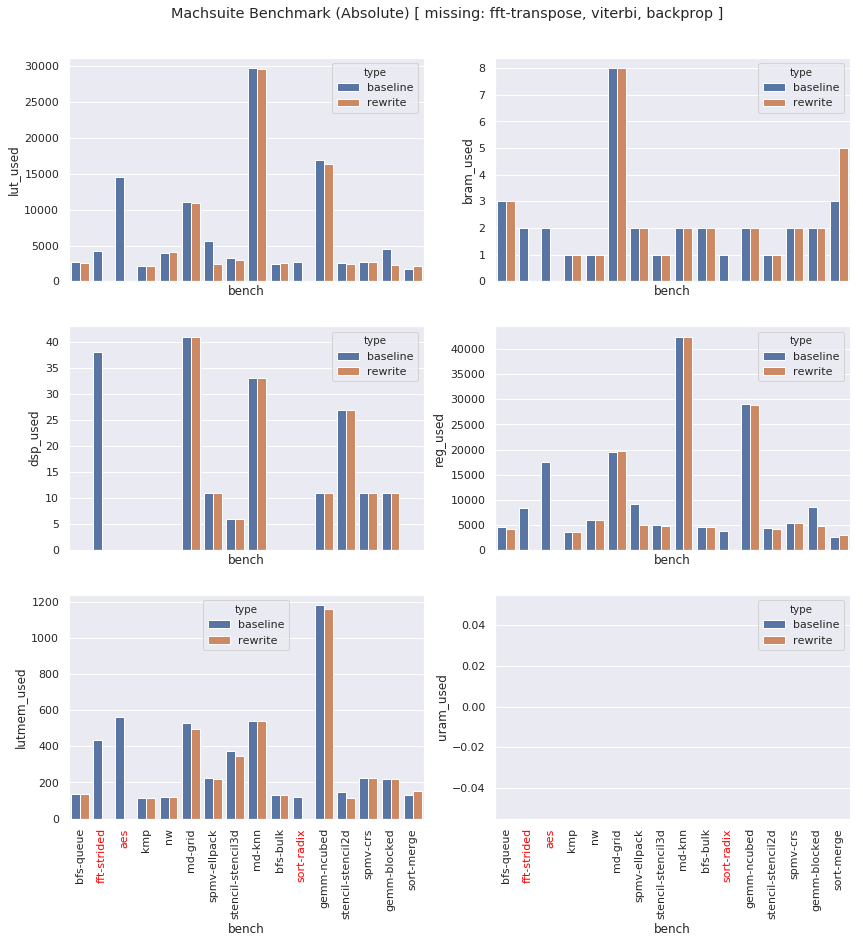

In [20]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(math.ceil(len(keys) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 14), sharex=True)

for idx, key in enumerate(keys):
    # Get current axes for the subplot
    ax = axes[int(idx / cols), idx % cols]
    sns.barplot(x='bench', y=key, hue='type', data=df, ax=ax)
    ax.tick_params(labelrotation=90, axis='x')
    [ t.set_color('red') for t in ax.xaxis.get_ticklabels() if t.get_text() in rewrite_missing ]

title = 'Machsuite Benchmark (Absolute)'
if len(baseline_missing) != 0:
    title += ' [ missing: ' + ', '.join(list(baseline_missing)) + ' ]'
    
fig.suptitle(title, y=0.93)

In [12]:
fig.savefig('absolute.png', dpi=300)

In [9]:
# Create join with baseline and rewrite data.
df_norm = df_rewrite.set_index('bench').join(df_baseline.set_index('bench'), lsuffix='_rewrite', rsuffix='_baseline')
for key in keys:
    df_norm[key] = df_norm[key + '_rewrite'] / df_norm[key + '_baseline']

df_norm.reset_index(inplace=True)
df_norm.fillna(value=0, inplace=True)

Text(0.5, -0.02, 'Machsuite Benchmark (Normalized) [ missing: viterbi, fft-transpose, backprop, sort-radix, aes, fft-strided ]')

<Figure size 432x288 with 0 Axes>

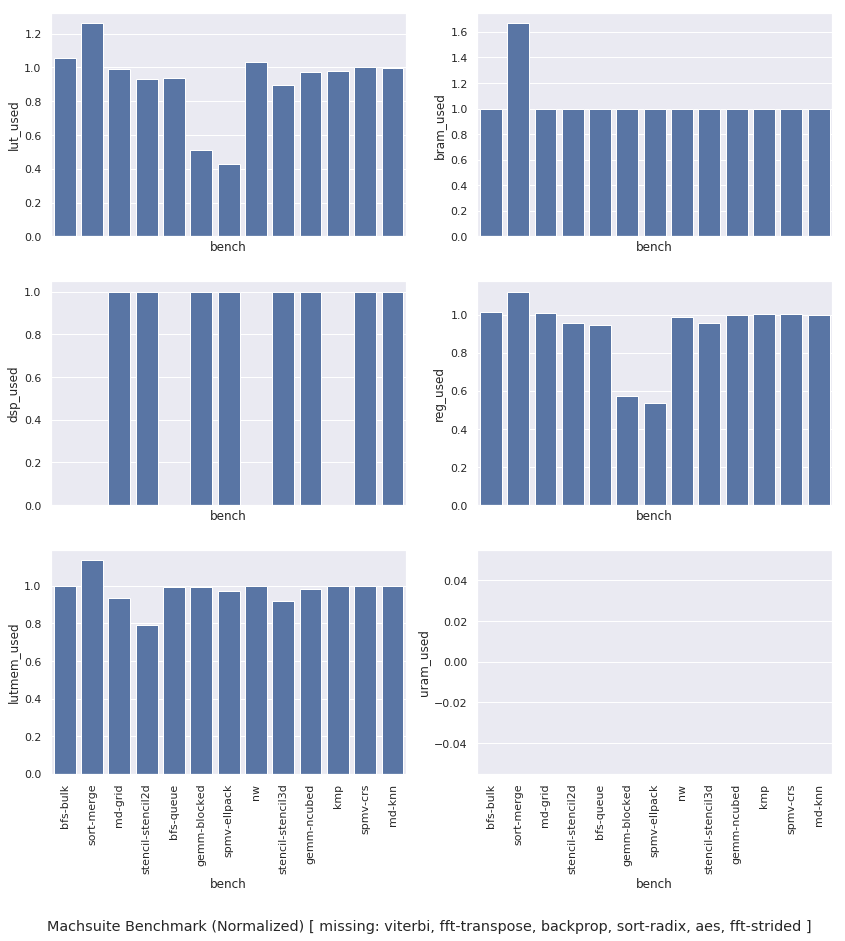

In [10]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(math.ceil(len(keys) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 14), sharex=True)

for idx, key in enumerate(keys):
    # Get current axes for the subplot
    ax = axes[int(idx / cols), idx % cols]
    sns.barplot(x='bench', y=key, data=df_norm, ax=ax, color=sns.color_palette()[0])
    ax.tick_params(labelrotation=90, axis='x')

title = 'Machsuite Benchmark (Normalized)'
missing = list(baseline_missing) + list(rewrite_missing)
if len(missing) != 0:
    title += ' [ missing: ' + ', '.join(missing) + ' ]'
    
fig.suptitle(title, y=0.93)

In [11]:
fig.savefig('normalized.png', dpi=300)